# Quick, Draw!

#### Divya Sanathkumar




The Quick Draw dataset is a collection of images hand drawn by users which consists of about 340 classes. The goal is to build a Neural network that tries to classify these hand drawn images. In order to do that, a Convolutional Neural Networks, used to analyze visual imagery, is built. The data is split into training and validation sets and is fed to this CNN model to predict the accuracy of the image recognition.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
from tqdm import tqdm
from PIL import Image

from sklearn.preprocessing import LabelEncoder

import keras
from keras.models import Sequential
from keras.layers import *

import tensorflow as tf
from tensorflow.keras.models import Model

# Load and Prep Data

In [2]:
candle_data = pd.read_csv('../input/quickdraw-doodle-recognition/train_simplified/candle.csv')
candle_data.head()

countrycode                                            drawing  \
0          TW  [[[63, 64, 68, 74, 126, 138, 149, 159, 164, 16...   
1          FI  [[[15, 26, 28, 33, 104, 92, 88, 83, 50, 0], [2...   
2          US  [[[9, 60, 86, 118, 118, 93, 55, 34, 0, 28, 56]...   
3          US  [[[7, 0], [255, 177]], [[5, 2, 3, 83, 73, 72],...   
4          IN  [[[5, 9, 12, 20, 25, 32, 31], [83, 86, 97, 198...   

             key_id  recognized                   timestamp    word  
0  5871980177784832        True  2017-01-28 04:11:00.727520  candle  
1  5858136034377728        True  2017-03-19 14:36:14.652940  candle  
2  6377906869633024        True  2017-03-17 20:13:24.222960  candle  
3  6413533405249536        True  2017-03-01 19:13:04.935000  candle  
4  6509722804944896        True  2017-03-24 09:44:00.185940  candle

In [3]:
strokes_str = candle_data.drawing[50]
print(type(strokes_str))
print(strokes_str)

<class 'str'>
[[[29, 14, 0, 15, 47, 48, 44, 25], [68, 70, 79, 83, 80, 76, 73, 71]], [[0, 3, 4, 1, 17, 38, 41, 41, 47], [83, 90, 155, 246, 254, 255, 251, 164, 94]], [[22, 23], [70, 41]], [[33, 29, 22, 8, 8, 21, 30, 34, 37, 34], [0, 1, 13, 26, 35, 39, 39, 36, 23, 1]]]


In [4]:
strokes_list = eval(strokes_str)
print(type(strokes_list))
print(len(strokes_list))

for s in strokes_list:
    print(s)

<class 'list'>
4
[[29, 14, 0, 15, 47, 48, 44, 25], [68, 70, 79, 83, 80, 76, 73, 71]]
[[0, 3, 4, 1, 17, 38, 41, 41, 47], [83, 90, 155, 246, 254, 255, 251, 164, 94]]
[[22, 23], [70, 41]]
[[33, 29, 22, 8, 8, 21, 30, 34, 37, 34], [0, 1, 13, 26, 35, 39, 39, 36, 23, 1]]


## Label Encoder

In [5]:
path = os.listdir('../input/quickdraw-doodle-recognition/train_simplified')
uniq_labels = np.array(sorted([x[:-4] for x in path]))

In [6]:
print(len(uniq_labels))
print(uniq_labels[:20])

340
['The Eiffel Tower' 'The Great Wall of China' 'The Mona Lisa' 'airplane'
 'alarm clock' 'ambulance' 'angel' 'animal migration' 'ant' 'anvil'
 'apple' 'arm' 'asparagus' 'axe' 'backpack' 'banana' 'bandage' 'barn'
 'baseball' 'baseball bat']


In [7]:
enc = LabelEncoder()
enc.fit(uniq_labels)

temp = uniq_labels[[0, 37, 42]] 
print(temp)
print(enc.transform(temp))

['The Eiffel Tower' 'book' 'brain']
[ 0 37 42]


In [8]:
label_lookup = pd.DataFrame({
    'label' : list(map(lambda x : x.replace(' ', '_'), uniq_labels)),
})

label_lookup.head()

label
0         The_Eiffel_Tower
1  The_Great_Wall_of_China
2            The_Mona_Lisa
3                 airplane
4              alarm_clock

In [9]:
label_lookup.to_csv('path' + 'label_lookup.csv', header=True, index=False)

## Batch Size and Steps Per Epoch

In [10]:
n_train = 24854214
n_valid = 24854043

print(n_train)
print(n_valid)

24854214
24854043


In [11]:
bs = 64

train_steps = 100
valid_steps = 100

print(train_steps)
print(valid_steps)

100
100


# Training and Validation Sets

In [12]:
train_temp = pd.read_csv('../input/quickdrawcombined/train.csv', chunksize=bs)
next(train_temp)

drawing        word
0   [[[131,123,126,145,226,217,187,151,119,0,184,2...        star
1   [[[51,47,49,142,173,199,209,213,209,202,192,17...       purse
2   [[[3,7,17,24,27,32,33,36,47,67,81,90,98,94,86,...        hand
3   [[[1,1,11,10,4,9,14,36,46,51,54,65,49,43,41,37...       fence
4   [[[6,135,171,199,201,198,193,181,165,125,92,52...         cup
..                                                ...         ...
59  [[[19,247,255,113,14,3,1,0,8,30],[181,182,117,...       bench
60  [[[26,12,12,19,31,59,68,82,87,87,78,60,0],[62,...  binoculars
61  [[[28,30,26,26,18,12,21,52,176,251,253,249,237...      pillow
62  [[[2,1,0,10,14,29,30,27,20,20,28,36,47,52],[40...     mermaid
63  [[[82,67,35,20,16,19,35,76,90,110,116,120,114,...     snowman

[64 rows x 2 columns]

In [13]:
train = pd.read_csv('../input/quickdrawcombined/train.csv', chunksize=bs)
valid = pd.read_csv('../input/quickdrawcombined/valid.csv', chunksize=bs)

# Data Generators

## img_to_np Function

In [14]:
def img_to_np(img_str, ht, wt, lw, pad):
    if img_str == 'drawing':
        print(np.zeros((ht, wt), np.uint8))
    
    strokes = eval(img_str)
    
    ht_ = ht - 2*pad
    wt_ = wt - 2*pad
    
    img = np.zeros((ht, wt), np.uint8)

    for s in strokes:
        sx = (np.array(s[0]) * wt_ / 256).round().astype('int') + pad
        sy = (np.array(s[1]) * ht_ / 256).round().astype('int') + pad
        for i in range(len(sx) - 1):
            p1 = (sx[i],   sy[i])
            p2 = (sx[i+1], sy[i+1])
            img = cv2.line(img, p1, p2, (255, 0, 0), lw, lineType=cv2.LINE_AA)
            
    return img

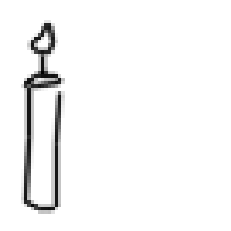

In [15]:
img_array = img_to_np(strokes_str, 64,64,1,5)

plt.imshow(img_array, cmap='binary')
plt.axis('off')
plt.show()

## Create Generator

In [16]:
class DataGenerator(keras.utils.Sequence):
    
    #####################################################################
    # Constructor
    # - df is a TextFileReader for reading in DataFrame
    #####################################################################
    def __init__(self, df, n_classes, batch_size, n_steps, img_params):
        #self.path = path
        self.df = df
        self.n_classes = n_classes
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.img_params = img_params
        
    #####################################################################
    # __getitem__ 
    # This is directly called by Keras methods. It returns a single 
    # batch of data. 
    #####################################################################
    def __getitem__(self, index):
        
        # Typically, this would determine the rows to select for the
        # current batch. In our case, we will simply grab the next 
        # batch from the TextFileReader

        X, y = self.__data_generation(index)

        return X, y

    #####################################################################
    # __data_generation 
    # This is called by __getitem__ to generate the batch.
    #####################################################################
    def __data_generation(self, index):

        # Get next batch
        batch = next(self.df)

        # Create blank canvas
        ht, wt, lw, pad = self.img_params
        X = np.zeros(shape=(len(batch), ht, wt, 1))
        
        ###########################################################
        #print(index, len(batch), batch.columns)


        # Process each image in the batch
        for i, img_str in enumerate(batch.drawing.values):

            if img_str == 'drawing':
                img_str == batch.drawing.values[i+1]
                batch.word.values[i] = batch.word.values[i+1]

            X[i, :, :, 0] = img_to_np(img_str, ht, wt, lw, pad) / 255

        # Get batch labels
        labels = batch.word.values
        y = enc.transform(labels)

        return X, y

    def __len__(self):
        'Denotes the number of batches per epoch'
        return self.n_steps

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        return None

## Display Batch Images

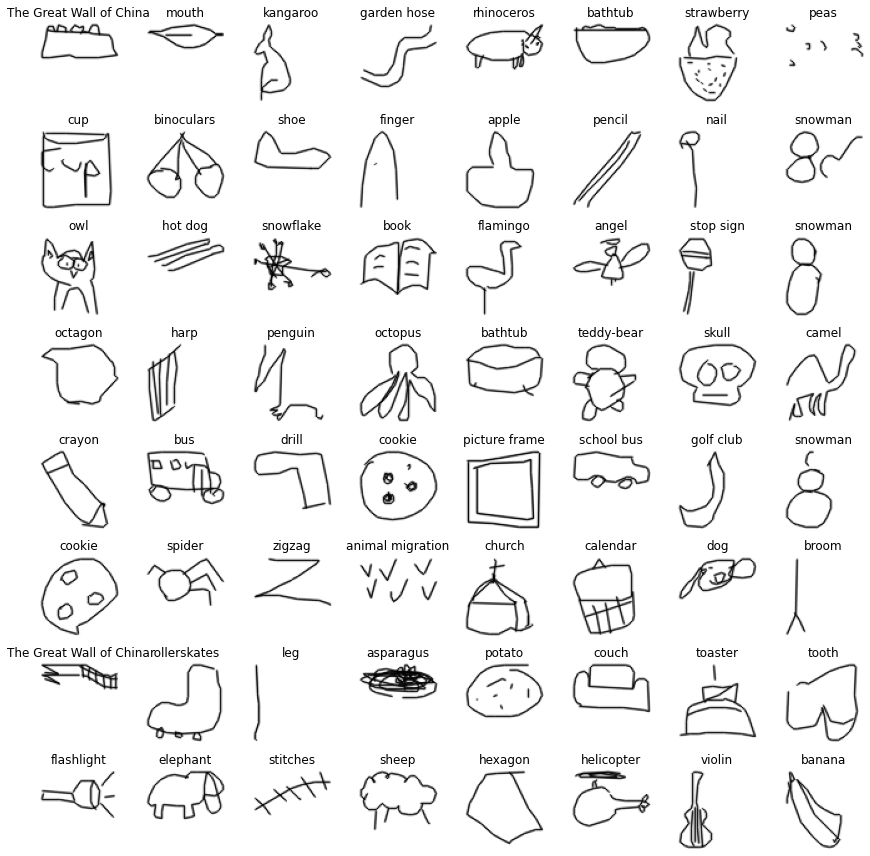

In [17]:
temp_dg = DataGenerator(train_temp, n_classes=20, batch_size=bs, n_steps=10,
                        img_params=(64, 64, 1, 2))

X, y = temp_dg.__getitem__(2)

labels = uniq_labels[y]

plt.figure(figsize=[12,12])
for i in range(64):
    plt.subplot(8,8,i+1)
    plt.imshow(X[i,:,:,0], cmap='binary')
    plt.title(labels[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

## Create Train and Valid Generators

In [18]:
train_dg = DataGenerator(train, batch_size=bs, n_classes=20, n_steps=train_steps,
                         img_params=(64, 64, 1, 2))

valid_dg = DataGenerator(valid, batch_size=bs, n_classes=20, n_steps=valid_steps,
                         img_params=(64, 64, 1, 2))

# CNN

## Build Network

In [19]:
np.random.seed(1)

cnn = Sequential()

cnn.add(Conv2D(128, (3,3), activation = 'relu', padding = 'same', input_shape=(64,64,1)))
cnn.add(Conv2D(128, (3,3), activation = 'relu', padding = 'same'))
cnn.add(MaxPooling2D(2,2))
cnn.add(BatchNormalization())

cnn.add(Conv2D(256, (3,3), activation = 'relu', padding = 'same'))
cnn.add(Conv2D(256, (3,3), activation = 'relu', padding = 'same'))
cnn.add(MaxPooling2D(2,2))
cnn.add(BatchNormalization())

cnn.add(Conv2D(512, (3,3), activation = 'relu', padding = 'same'))
cnn.add(Conv2D(512, (3,3), activation = 'relu', padding = 'same'))
cnn.add(MaxPooling2D(2,2))
cnn.add(BatchNormalization())

cnn.add(Conv2D(1024, (3,3), activation = 'relu', padding = 'same'))
cnn.add(Conv2D(1024, (3,3), activation = 'relu', padding = 'same'))
cnn.add(MaxPooling2D(2,2))
cnn.add(BatchNormalization())
cnn.add(Flatten())

cnn.add(Dense(2048, activation='relu'))
cnn.add(BatchNormalization())

cnn.add(Dense(1024, activation='relu'))
cnn.add(BatchNormalization())

cnn.add(Dense(512, activation='relu'))
cnn.add(BatchNormalization())

cnn.add(Dense(340, activation='softmax'))

In [20]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 128)       1280      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       147584    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 128)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 128)       512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 256)       295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 256)       590080    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 256)       0

## Train Network

### Run 1

In [21]:
%%time 

opt = keras.optimizers.Adam(0.001)
cnn.compile(loss='SparseCategoricalCrossentropy', optimizer=opt, metrics=['accuracy'])

h1 = cnn.fit(train_dg, validation_data=valid_dg,
             verbose=1, epochs=100, batch_size = 1000)

Epoch 1/100
100/100 [==============================] - 18s 131ms/step - loss: 5.7618 - accuracy: 0.0260 - val_loss: 10.8631 - val_accuracy: 0.0019
Epoch 2/100
100/100 [==============================] - 13s 127ms/step - loss: 4.7301 - accuracy: 0.0902 - val_loss: 8.5381 - val_accuracy: 0.0027
Epoch 3/100
100/100 [==============================] - 13s 128ms/step - loss: 4.1823 - accuracy: 0.1472 - val_loss: 14.1688 - val_accuracy: 0.0028
Epoch 4/100
100/100 [==============================] - 13s 127ms/step - loss: 3.8815 - accuracy: 0.1897 - val_loss: 10.2135 - val_accuracy: 0.0066
Epoch 5/100
100/100 [==============================] - 13s 130ms/step - loss: 3.5487 - accuracy: 0.2310 - val_loss: 7.5247 - val_accuracy: 0.0328
Epoch 6/100
100/100 [==============================] - 13s 125ms/step - loss: 3.3560 - accuracy: 0.2593 - val_loss: 3.3860 - val_accuracy: 0.2706
Epoch 7/100
100/100 [==============================] - 12s 125ms/step - loss: 3.1446 - accuracy: 0.2975 - val_loss: 3.479

## Create Function to display plot

In [22]:
def vis_training(hlist, start=1, size=[12,6], show_val=True):
    tr_loss = []
    va_loss = []
    tr_acc = []
    va_acc = []
    for h in hlist:
        tr_loss += h.history['loss'] 
        va_loss += h.history['val_loss']
        tr_acc += h.history['accuracy'] 
        va_acc += h.history['val_accuracy']
    
    plt.figure(figsize = size)
    a = start
    b = len(tr_loss) + 1
    plt.subplot(1,2,1)
    plt.plot(range(a,b), tr_loss[a-1:], label='Training')
    if(show_val): 
        plt.plot(range(a,b), va_loss[a-1:], label='Validation')
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.grid()
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(range(a,b), tr_acc[a-1:], label='Training')
    if(show_val):  
        plt.plot(range(a,b), va_acc[a-1:], label='Validation')
    plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.grid()
    plt.legend()
    plt.show()

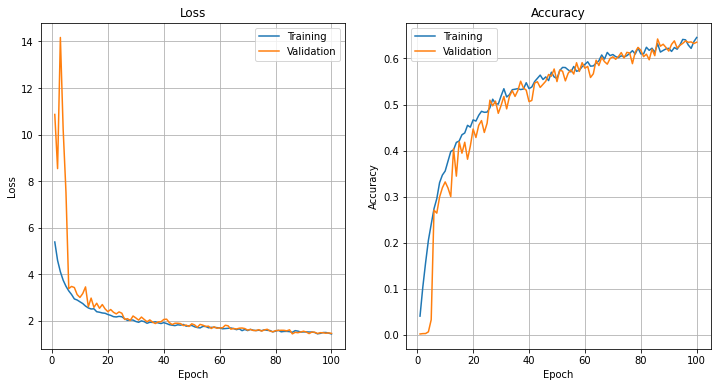

In [23]:
vis_training([h1])

### Run 2

In [24]:
h2 = cnn.fit(train_dg, validation_data=valid_dg,
             verbose=1, epochs=100,batch_size=100)

Epoch 1/100
100/100 [==============================] - 13s 128ms/step - loss: 1.4736 - accuracy: 0.6330 - val_loss: 1.5213 - val_accuracy: 0.6252
Epoch 2/100
100/100 [==============================] - 13s 126ms/step - loss: 1.4879 - accuracy: 0.6331 - val_loss: 1.4284 - val_accuracy: 0.6433
Epoch 3/100
100/100 [==============================] - 13s 133ms/step - loss: 1.4623 - accuracy: 0.6361 - val_loss: 1.4432 - val_accuracy: 0.6491
Epoch 4/100
100/100 [==============================] - 13s 128ms/step - loss: 1.4726 - accuracy: 0.6314 - val_loss: 1.4734 - val_accuracy: 0.6383
Epoch 5/100
100/100 [==============================] - 13s 126ms/step - loss: 1.4763 - accuracy: 0.6286 - val_loss: 1.4383 - val_accuracy: 0.6450
Epoch 6/100
100/100 [==============================] - 13s 129ms/step - loss: 1.4057 - accuracy: 0.6569 - val_loss: 1.4368 - val_accuracy: 0.6422
Epoch 7/100
100/100 [==============================] - 12s 125ms/step - loss: 1.4517 - accuracy: 0.6322 - val_loss: 1.4093 -

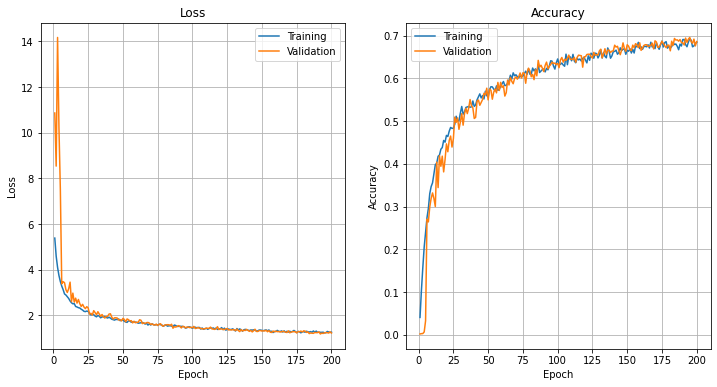

In [25]:
vis_training([h1,h2])

### Run 3

In [26]:
keras.backend.set_value(cnn.optimizer.learning_rate, 0.0001)
h3 = cnn.fit(train_dg, validation_data=valid_dg,
             verbose=1, epochs=100,batch_size=100)

Epoch 1/100
100/100 [==============================] - 13s 127ms/step - loss: 1.2489 - accuracy: 0.6872 - val_loss: 1.1847 - val_accuracy: 0.7013
Epoch 2/100
100/100 [==============================] - 13s 126ms/step - loss: 1.2262 - accuracy: 0.6958 - val_loss: 1.1704 - val_accuracy: 0.7092
Epoch 3/100
100/100 [==============================] - 13s 125ms/step - loss: 1.2598 - accuracy: 0.6875 - val_loss: 1.1589 - val_accuracy: 0.7116
Epoch 4/100
100/100 [==============================] - 13s 130ms/step - loss: 1.2104 - accuracy: 0.7022 - val_loss: 1.1351 - val_accuracy: 0.7188
Epoch 5/100
100/100 [==============================] - 12s 125ms/step - loss: 1.1666 - accuracy: 0.7095 - val_loss: 1.1241 - val_accuracy: 0.7184
Epoch 6/100
100/100 [==============================] - 14s 142ms/step - loss: 1.1600 - accuracy: 0.7166 - val_loss: 1.1346 - val_accuracy: 0.7144
Epoch 7/100
100/100 [==============================] - 12s 123ms/step - loss: 1.1454 - accuracy: 0.7097 - val_loss: 1.1153 -

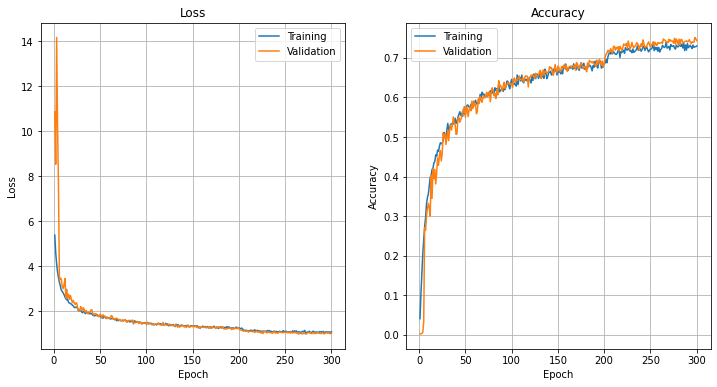

In [27]:
vis_training([h1, h2, h3])

# Evaluate the Model

## Distribution of Top 3 Probabilities

In [28]:
def get_top_3(probs):
    top_classes = np.argpartition(probs, -3)[-3:]                  # Gives top 3 classes in increasing order
    top_classes = top_classes[np.argsort(probs[top_classes])]      # Sorts in increasing order
    top_classes = np.flip(top_classes)                             # Flips the order.
    top_probs = probs[top_classes]              

    return top_probs, top_classes

(6400, 3)


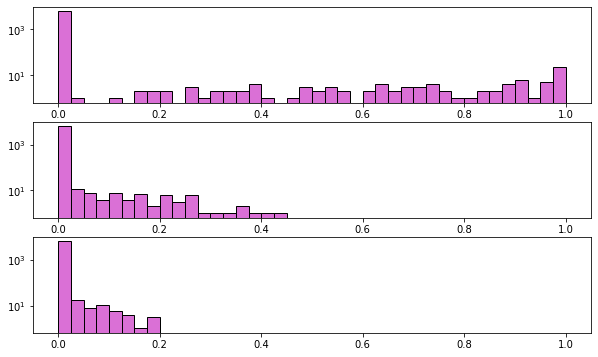

In [29]:
NB = len(train_dg)
#NB = 10

top_3_probs = np.zeros(shape=(64*NB, 3))

for i in range(NB):
    batch_imgs, batch_labels = train_dg.__getitem__(i)
    batch_pred = cnn.predict(batch_imgs)

    ## Loop over each image in the batch
    for j in range(64):
        top_probs, top_classes = get_top_3(batch_pred[j, :])
        top_3_probs[i,:] = top_probs

print(top_3_probs.shape)

plt.figure(figsize=[10,6])
for i in range(3):
    plt.subplot(3,1,i+1)
    plt.hist(top_3_probs[:,i], color='orchid', edgecolor='k', bins = np.arange(0, 1.01, 0.025))
    plt.yscale('log')
plt.show()

# MAP at 3

In [30]:
def MAP3(t):
    NB = len(valid_dg)
    #NB = 20

    sum_ap3 = 0
    N_obs = 0

    for i in range(NB):
        batch_imgs, batch_labels = train_dg.__getitem__(i)
        batch_pred = cnn.predict(batch_imgs)

        ## Loop over each image in the batch
        for j in range(64):
            probs = batch_pred[j, :]
            top_classes = np.argpartition(probs, -3)[-3:]                  # Gives top 3 classes in increasing order
            top_classes = top_classes[np.argsort(probs[top_classes])]      # Sorts in increasing order
            top_classes = np.flip(top_classes)                             # Flips the order.

            top_probs = probs[top_classes]              # Don't need this when not using a threshold

            # Keep Probs Over Threshold
            sel = top_probs > t
            sel[0] = True                               # Always keep first pred
            top_classes = top_classes[sel]

            K = len(top_classes)   # Number of classes to submit
            if K == 3:
                scores = np.array([11/18, 5/18, 2/18])
            elif K == 2:
                scores = np.array([3/4, 1/4])
            else:
                scores = np.array([1])
            
            sel = (top_classes == batch_labels[j])
            ap3 = np.sum(scores * sel)

            sum_ap3 += ap3
            N_obs += 1
            
            #print(ap3)

    map3 = sum_ap3 / N_obs

    return map3

for t in np.arange(0, 1.01, 0.05):
    print(round(t, 2), '\t', MAP3(t))

0.0 	 0.48637152777782433
0.05 	 0.6734592013889045
0.1 	 0.7048741319444509
0.15 	 0.7231944444444466
0.2 	 0.7212586805555561
0.25 	 0.7365234375
0.3 	 0.7391015625
0.35 	 0.7473828125
0.4 	 0.73671875
0.45 	 0.7373828125
0.5 	 0.7428125
0.55 	 0.74484375
0.6 	 0.7284375
0.65 	 0.7403125
0.7 	 0.73875
0.75 	 0.73765625
0.8 	 0.7403125
0.85 	 0.73546875
0.9 	 0.74046875
0.95 	 0.73453125
1.0 	 0.74078125


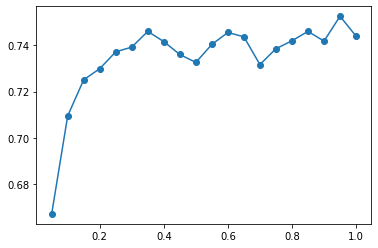

CPU times: user 2min 34s, sys: 3.6 s, total: 2min 37s
Wall time: 2min 58s


In [31]:
%%time

MAP3_scores = []
t_array = np.arange(0.05, 1.01, 0.05) 

for t in t_array:
    MAP3_scores.append(MAP3(t))

plt.plot(t_array, MAP3_scores)
plt.scatter(t_array, MAP3_scores)
plt.show()

# CAM

## Create CAM Function

In [32]:
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        if self.layerName is None:
            self.layerName = self.find_target_layer()
            
    def find_target_layer(self):
        for layer in reversed(self.model.layers):
            if len(layer.output_shape) == 4:
                return layer.name
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")
        
    def compute_heatmap(self, image, eps=1e-8):
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output,self.model.output]
       )
           
        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]
            grads = tape.gradient(loss, convOutputs)

            castConvOutputs = tf.cast(convOutputs > 0, "float32")
            castGrads = tf.cast(grads > 0, "float32")
            guidedGrads = castConvOutputs * castGrads * grads
            convOutputs = convOutputs[0]
            guidedGrads = guidedGrads[0]

            weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
            cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

            (w, h) = (image.shape[2], image.shape[1])
            heatmap = cv2.resize(cam.numpy(), (w, h))
            numer = heatmap - np.min(heatmap)
            denom = (heatmap.max() - heatmap.min()) + eps
            heatmap = numer / denom
            heatmap = (heatmap * 255).astype("uint8")
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
        colormap = cv2.COLORMAP_VIRIDIS):
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        return (heatmap, output)

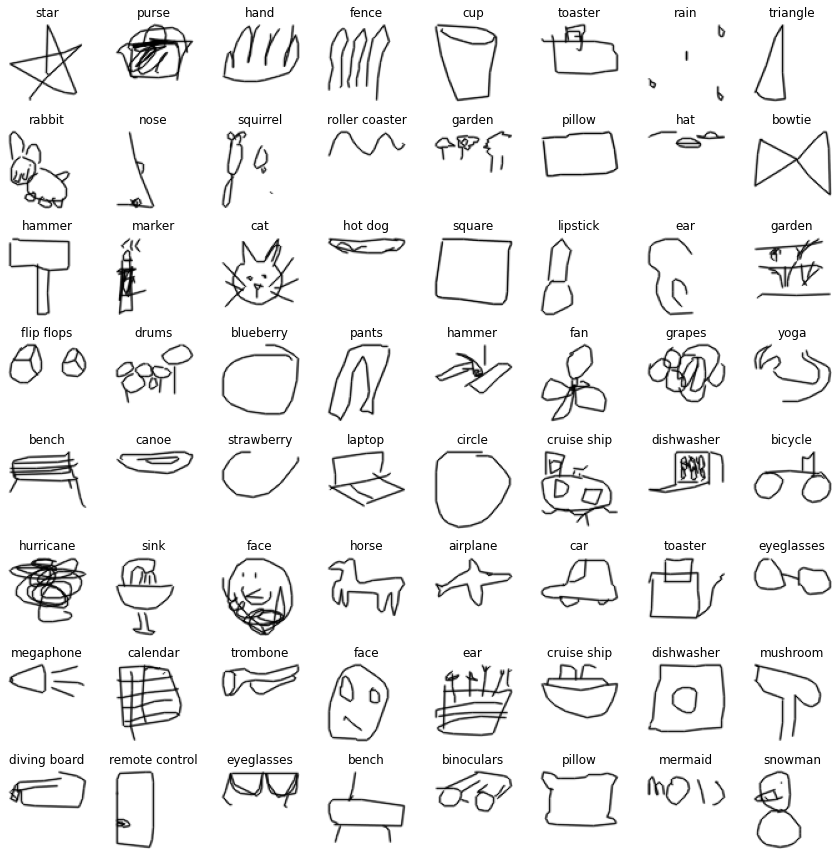

In [33]:
train_new = pd.read_csv('../input/quickdrawcombined/train.csv', chunksize=bs)

train_dg = DataGenerator(train_new, batch_size=bs, n_classes=20, n_steps=train_steps,
                         img_params=(64, 64, 1, 2))

X, y = train_dg.__getitem__(2)

labels = uniq_labels[y]

plt.figure(figsize=[12,12])
for i in range(64):
    plt.subplot(8,8,i+1)
    plt.imshow(X[i,:,:,0], cmap='binary')
    plt.title(labels[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [34]:
batch_pred = cnn.predict(X)
batch_pred.shape

(64, 340)

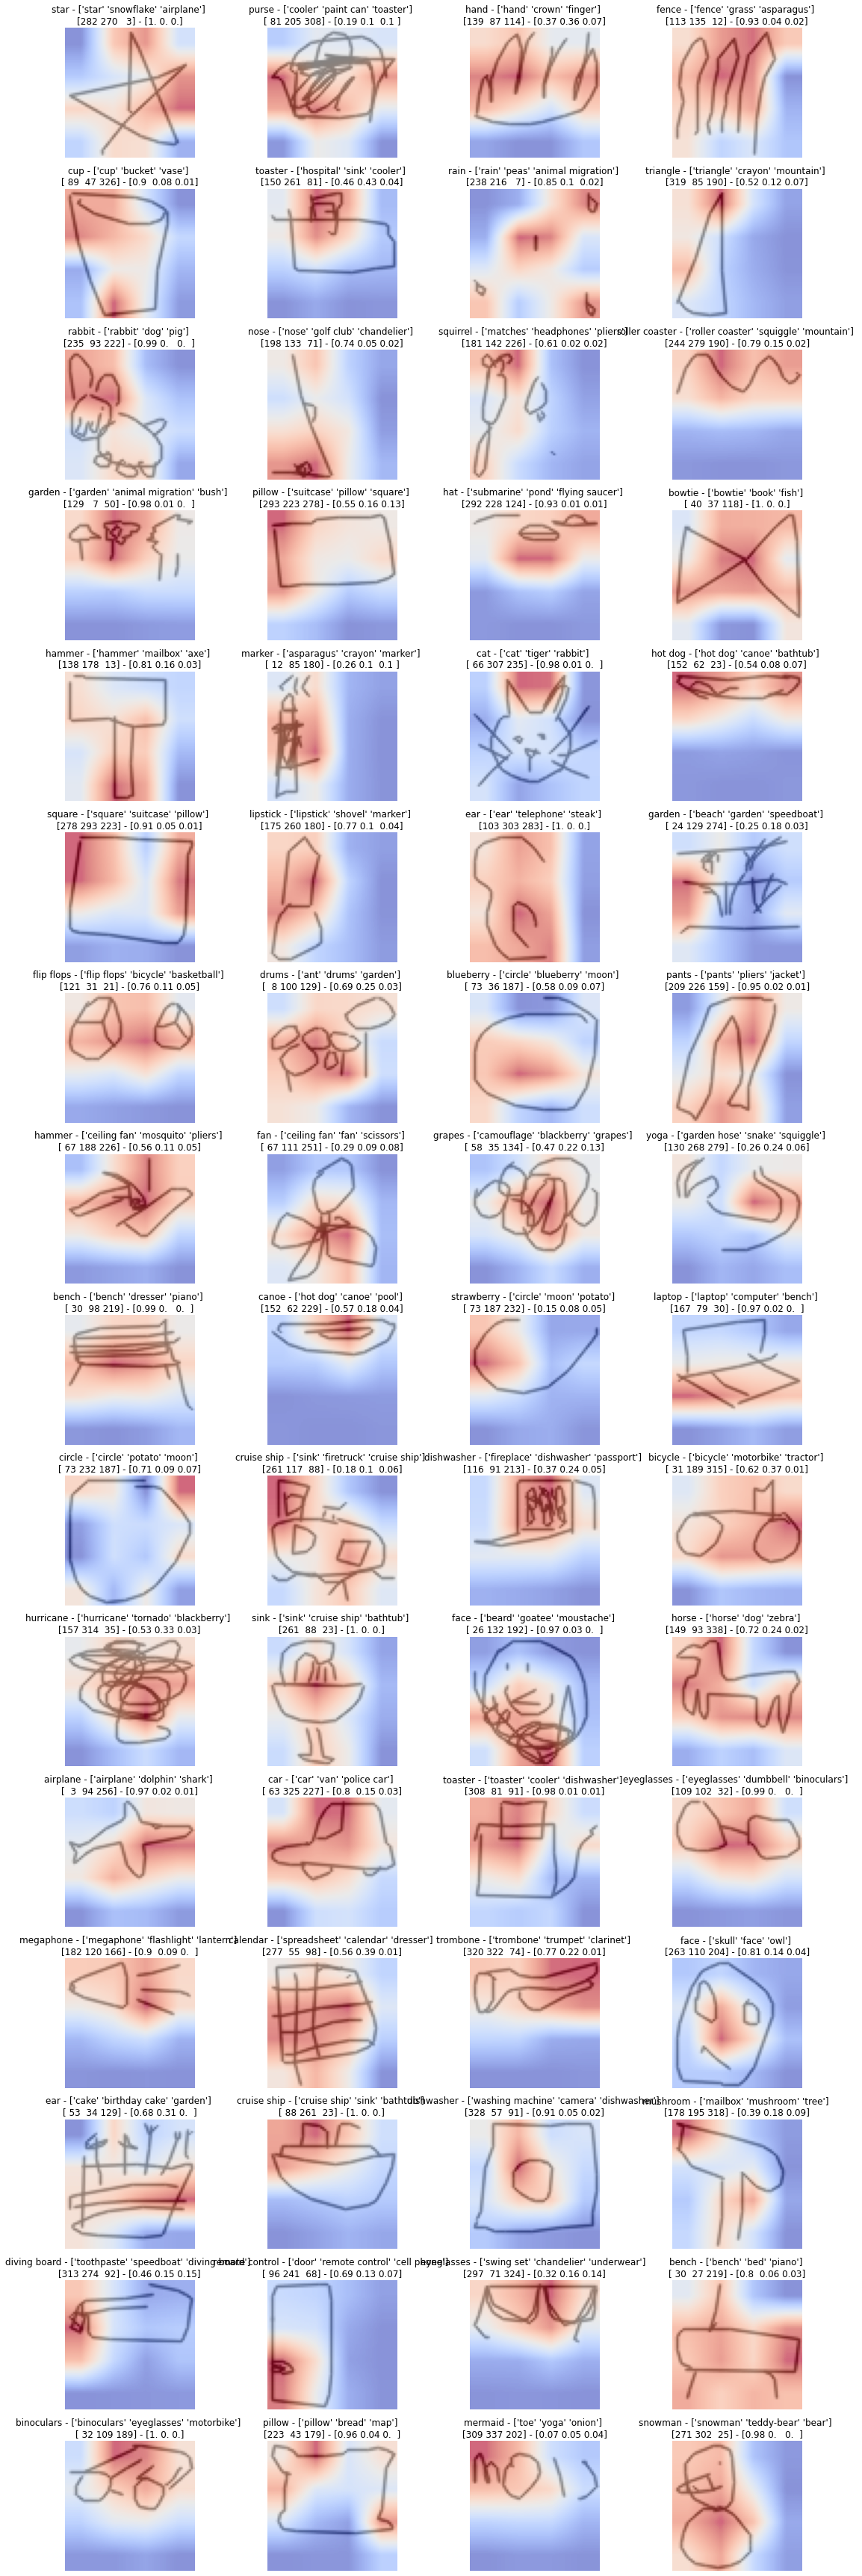

In [35]:
plt.figure(figsize=[16,48])
for n in range(64):

    top_probs, top_classes = get_top_3(batch_pred[n, :])
    
    cam = GradCAM(cnn, top_classes[0])             
    heatmap = cam.compute_heatmap(X[[n], :, :, :]) 

    plt.subplot(16,4,n+1)
    plt.imshow(X[n,:,:,0], cmap='binary')
    plt.imshow(heatmap, alpha=0.6, cmap='coolwarm')
    plt.title(f'{labels[n]} - {uniq_labels[top_classes]} \n{top_classes} - {top_probs.round(2)}')
    plt.axis('off')
    
plt.tight_layout()
plt.show()

# Save the Model

In [36]:
cnn.save('demo_model.h5')

# Load Test Data

In [37]:
test = pd.read_csv('../input/quickdraw-doodle-recognition/test_simplified.csv')
print(test.shape)
test.head()

(112199, 3)


key_id countrycode  \
0  9000003627287624          DE   
1  9000010688666847          UA   
2  9000023642890129          BG   
3  9000038588854897          US   
4  9000052667981386          AR   

                                             drawing  
0  [[[17, 18, 20, 25, 137, 174, 242, 249, 251, 25...  
1  [[[174, 145, 106, 38, 11, 4, 4, 15, 29, 78, 16...  
2  [[[0, 12, 14, 17, 16, 24, 55, 57, 60, 79, 82, ...  
3  [[[0, 9, 23, 40, 54, 60, 81, 105, 123, 167, 20...  
4  [[[87, 82, 71, 63, 66, 92, 96, 95], [220, 218,...

## Convert Test Strings to Arrays

In [38]:
def img_to_np(img_str, ht, wt, lw, pad):

    strokes = eval(img_str)

    ht_ = ht - 2*pad
    wt_ = wt - 2*pad

    img = np.zeros((ht, wt), np.uint8)

    for s in strokes:
        sx = (np.array(s[0]) * wt_ / 256).round().astype('int') + pad
        sy = (np.array(s[1]) * ht_ / 256).round().astype('int') + pad

        for i in range(len(sx) - 1):
            p1 = (sx[i],   sy[i])
            p2 = (sx[i+1], sy[i+1])
            img = cv2.line(img, p1, p2, (255, 0, 0), lw, lineType=cv2.LINE_AA)
            #img = cv2.resize(img, (ht, wt))
    return img

In [39]:
test_imgs = np.zeros(shape = (test.shape[0], 64, 64, 1))

In [40]:
%%time

for i, row in test.iterrows():
    test_imgs[i,:,:,0] = img_to_np(row.drawing, 64, 64, 1, 2) / 255

CPU times: user 1min 12s, sys: 2.6 s, total: 1min 15s
Wall time: 1min 16s


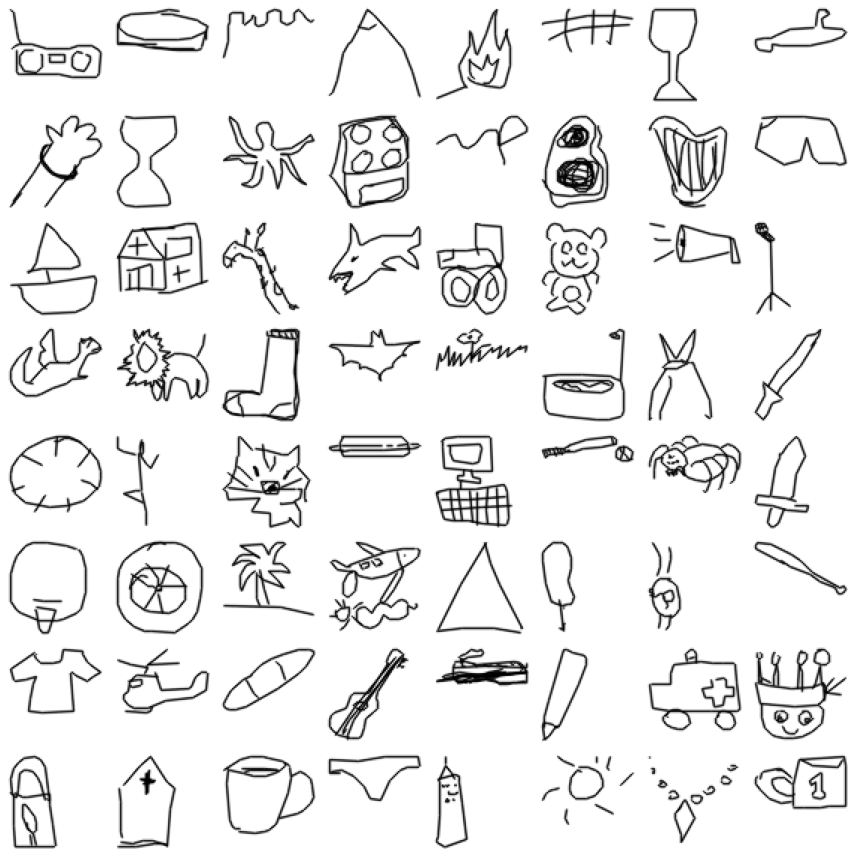

In [41]:
plt.figure(figsize=[12,12])
for i in range(64):
    plt.subplot(8,8,i+1)
    plt.imshow(test_imgs[i,:,:,0], cmap='binary')
    plt.axis('off')
plt.tight_layout()
plt.show()

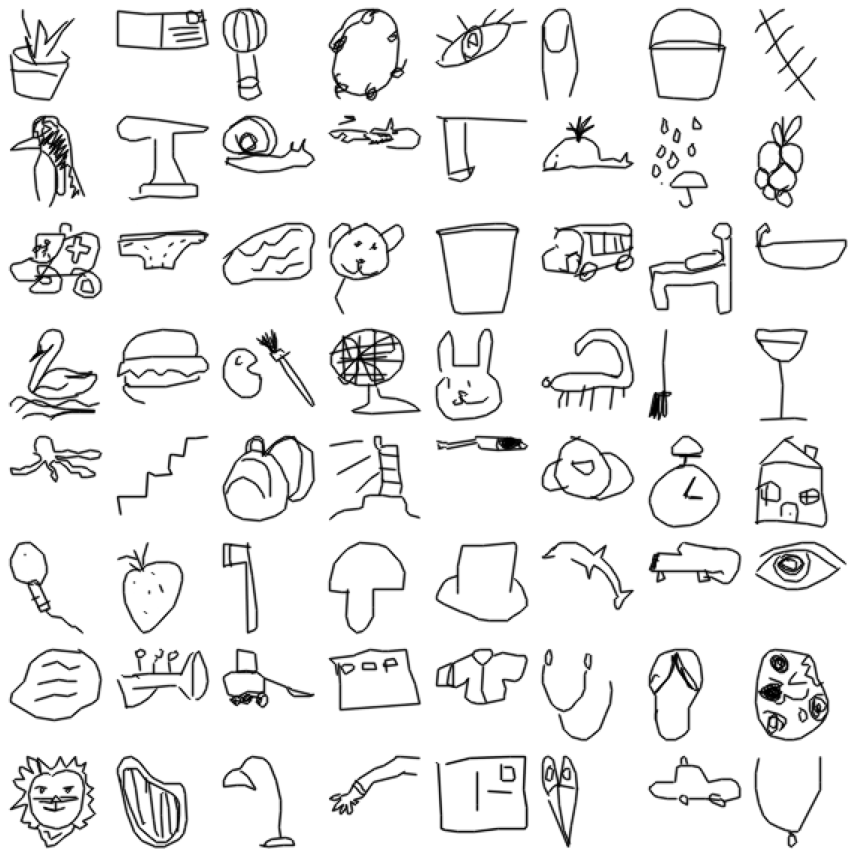

In [42]:
sample = test.sample(64)
sample.shape

plt.figure(figsize=[12,12])
for i in range(64):
    plt.subplot(8,8,i+1)
    plt.imshow(img_to_np(sample.drawing.values[i], 64, 64, 1, 2), cmap='binary')
    plt.axis('off')
plt.tight_layout()
plt.show()

## Load Model

In [43]:
cnn = keras.models.load_model('./demo_model.h5')
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 128)       1280      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       147584    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 128)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 128)       512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 256)       295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 256)       590080    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 256)       0

## Generate Predictions

In [44]:
test_imgs.shape

(112199, 64, 64, 1)

In [45]:
%%time 

probs = cnn.predict(test_imgs)

print(probs.shape)

(112199, 340)
CPU times: user 11.6 s, sys: 3.29 s, total: 14.9 s
Wall time: 48.6 s


## Distribution of Top 3 Probabilities

[[0.69 0.31 0.  ]
 [0.79 0.09 0.05]
 [0.95 0.03 0.02]
 [1.   0.   0.  ]
 [0.63 0.37 0.  ]
 [0.76 0.1  0.04]
 [1.   0.   0.  ]
 [0.94 0.02 0.01]
 [0.55 0.08 0.08]
 [1.   0.   0.  ]]
(112199, 3)


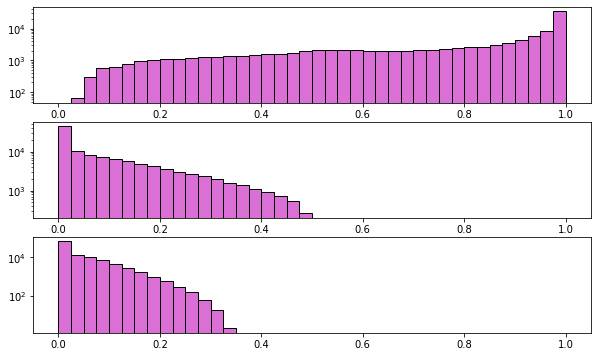

In [46]:
N_train = probs.shape[0]
top_3_probs = np.zeros(shape=(N_train, 3))

for i in range(N_train):
    p = probs[i, :]
    top_classes = np.argpartition(p, -3)[-3:]                      # Gives top 3 classes in increasing order
    top_classes = top_classes[np.argsort(p[top_classes])]      # Sorts in increasing order
    top_classes = np.flip(top_classes)                             # Flips the order.

    top_probs = p[top_classes]              

    top_3_probs[i,:] = top_probs
    
print(top_3_probs[:10, :].round(2))

print(top_3_probs.shape)

plt.figure(figsize=[10,6])
for i in range(3):
    plt.subplot(3,1,i+1)
    plt.hist(top_3_probs[:,i], color='orchid', edgecolor='k', bins = np.arange(0, 1.01, 0.025))
    plt.yscale('log')
plt.show()

## Determine Predictions

In [47]:
N_train = probs.shape[0]
predictions = []

t = 0.35

for i in range(N_train):
    p = probs[i, :]
    top_classes = np.argpartition(p, -3)[-3:]                   # Gives top 3 classes in increasing order
    top_classes = top_classes[np.argsort(p[top_classes])]       # Sorts in increasing order
    top_classes = np.flip(top_classes)                          # Flips the order.

    top_probs = p[top_classes]              

    # Keep Probs Over Threshold
    sel = top_probs > t
    sel[0] = True                               # Always keep first pred
    predictions.append(top_classes[sel])
    
print(len(predictions))

112199


# Create Submission

In [48]:
test.head()

key_id countrycode  \
0  9000003627287624          DE   
1  9000010688666847          UA   
2  9000023642890129          BG   
3  9000038588854897          US   
4  9000052667981386          AR   

                                             drawing  
0  [[[17, 18, 20, 25, 137, 174, 242, 249, 251, 25...  
1  [[[174, 145, 106, 38, 11, 4, 4, 15, 29, 78, 16...  
2  [[[0, 12, 14, 17, 16, 24, 55, 57, 60, 79, 82, ...  
3  [[[0, 9, 23, 40, 54, 60, 81, 105, 123, 167, 20...  
4  [[[87, 82, 71, 63, 66, 92, 96, 95], [220, 218,...

In [49]:
submission = pd.read_csv('../input/quickdraw-doodle-recognition/sample_submission.csv')
submission.head()

key_id                             word
0  9000003627287624  The_Eiffel_Tower airplane donut
1  9000010688666847  The_Eiffel_Tower airplane donut
2  9000023642890129  The_Eiffel_Tower airplane donut
3  9000038588854897  The_Eiffel_Tower airplane donut
4  9000052667981386  The_Eiffel_Tower airplane donut

In [50]:
len(submission)

112199

In [51]:
label_lookup_df = pd.read_csv('path' + 'label_lookup.csv')
label_lookup = {k:v for k,v in zip(label_lookup_df.index.values, label_lookup_df.label.values)}
label_lookup[0]

'The_Eiffel_Tower'

In [52]:
%%time

for i in range(N_train):
    classes = predictions[i]
    words_list = [label_lookup[c] for c in classes]
    words_string = ' '.join(words_list)
    submission.loc[i, 'word'] = words_string
    #print(words_string)
    
submission.head()

CPU times: user 2min 31s, sys: 50.3 ms, total: 2min 31s
Wall time: 2min 31s


key_id                     word
0  9000003627287624                    radio
1  9000010688666847              hockey_puck
2  9000023642890129  The_Great_Wall_of_China
3  9000038588854897                 mountain
4  9000052667981386       fireplace campfire

In [53]:
submission.to_csv('submission.csv', index=False)

# Images with Predictions

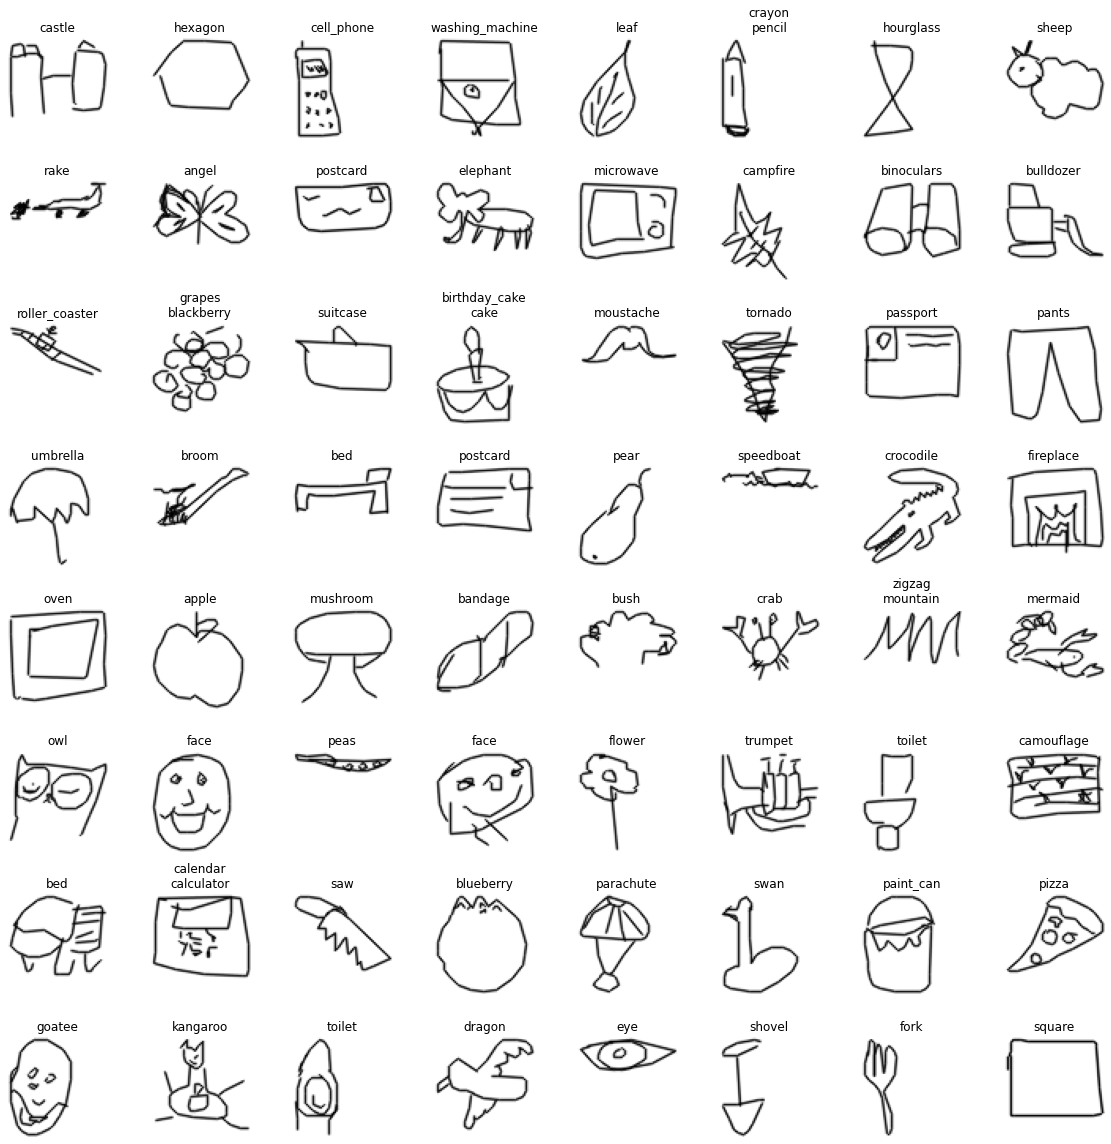

In [54]:
idx = np.random.choice(range(N_train), 64, replace=False)
test_sample = test.iloc[idx,:]
sub_sample = submission.iloc[idx, :]

plt.figure(figsize=[16,16])

for i in range(64):
    plt.subplot(8,8,i+1)
    plt.imshow(img_to_np(test_sample.drawing.values[i], 64, 64, 1, 2), cmap='binary')
    plt.title(sub_sample.word.values[i].replace(' ', '\n'))
    plt.axis('off')
plt.tight_layout()
plt.show()